In [1]:
import requests
from bs4 import BeautifulSoup
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from llama_cloud_services import LlamaParse
from typing import List, Optional, Annotated, Literal
import operator
import os
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

load_dotenv();

/tmp/ipykernel_12077/893083427.py:6: DeprecationWarning: This package (llama-cloud-services) is deprecated and will be maintained until May 1, 2026. Please migrate to the new package: pip install llama-cloud>=1.0 (https://github.com/run-llama/llama-cloud-py). The new package provides the same functionality with improved performance and support.
  from llama_cloud_services import LlamaParse


In [2]:
api_key = os.environ.get("LLAMA_PARSE_API_KEY")

parser_no_llm = LlamaParse(
    api_key=api_key,
    parse_mode="parse_page_without_llm",
)
result = parser_no_llm.parse("Resume.pdf")

text = ""
for page in result.pages:
    text = text + page.text

Started parsing the file under job_id b1964f7c-b0d6-48a5-a4bc-09d350ce6c8c


In [ ]:
class Experience(BaseModel):
    company: str
    role: str
    location: Optional[str] = None
    start_date: Optional[str] = None
    end_date: Optional[str] = None
    description: Optional[str] = None
    technologies: List[str] = []
    bullets: List[str]


class Project(BaseModel):
    title: str
    description: Optional[str] = None
    technologies: List[str] = []
    bullets: List[str]
    link: Optional[str] = None


class Education(BaseModel):
    institution: str
    degree: str
    field_of_study: Optional[str] = None
    location: Optional[str] = None
    start_date: Optional[str] = None
    end_date: Optional[str] = None
    gpa: Optional[str] = None


class SkillCategory(BaseModel):
    category: str
    skills: list[str]


class ResumeSchema(BaseModel):
    name: str
    email: Optional[str] = None
    phone: Optional[str] = None
    linkedin: Optional[str] = None
    github: Optional[str] = None
    summary: str
    skills: list[SkillCategory]
    experience: list[Experience]
    projects: list[Project]
    education: list[Education]

In [ ]:
ingestion_model = init_chat_model("gpt-5-nano").with_structured_output(ResumeSchema)


class IngestionState(BaseModel):
    raw_text: str = ""
    resume_json: Optional[ResumeSchema] = None

In [ ]:
def ingestion_node(state: IngestionState) -> IngestionState:
    messages = [
        {
            "role": "system",
            "content": "Extract resume information into structured JSON. Only extract what is explicitly present. No inference or embellishment. Skills must be atomic keywords with a category (1-3 words, no 'experience with'). Empty list if section missing.",
        },
        {"role": "user", "content": f"Resume:\n{state.raw_text}"},
    ]

    response = ingestion_model.invoke(messages)
    return {"resume_json": response}


def human_review_node(state: IngestionState) -> IngestionState:
    human_edits = interrupt(
        {
            "resume_json": state.resume_json.model_dump(),
            "message": "Please review and edit your extracted resume data.",
        }
    )

    return {"resume_json": ResumeSchema(**human_edits)}

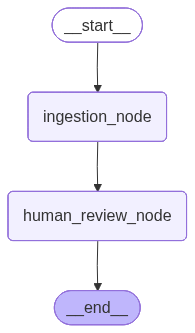

In [6]:
from IPython.display import Image, display

checkpointer = InMemorySaver()

ingestion_graph = StateGraph(IngestionState)
ingestion_graph.add_node("ingestion_node", ingestion_node)
ingestion_graph.add_node("human_review_node", human_review_node)
ingestion_graph.add_edge(START, "ingestion_node")
ingestion_graph.add_edge("ingestion_node", "human_review_node")
ingestion_graph.add_edge("human_review_node", END)

ingestion_agent = ingestion_graph.compile(checkpointer=checkpointer)

display(Image(ingestion_agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
config: RunnableConfig = {"configurable": {"thread_id": "1"}}

ingestion_agent_response = ingestion_agent.invoke({"raw_text": text}, config=config)
resume_json = ingestion_agent_response["resume_json"].model_dump()
print(ingestion_agent_response["resume_json"].model_dump_json(indent=4))

# async for mode, chunk in ingestion_agent.astream(
#     {"raw_text": text},
#     stream_mode=["messages", "updates"],
#     config=config,
# ):
#     print(f"Mode: {mode}, Chunk: {chunk}")

{
    "name": "Athreya Ganesh",
    "email": "athreyaganesh2000@gmail.com",
    "phone": "+353-899852521",
    "linkedin": "https://www.linkedin.com/in/athreya-ganesh",
    "github": null,
    "summary": "",
    "skills": [
        {
            "category": "Languages",
            "skills": [
                "Python",
                "R",
                "JavaScript",
                "SQL"
            ]
        },
        {
            "category": "Data Analysis & Visualization",
            "skills": [
                "NumPy",
                "Pandas",
                "Matplotlib",
                "ggplot2",
                "dplyr",
                "Power BI"
            ]
        },
        {
            "category": "Machine Learning",
            "skills": [
                "scikit-learn",
                "XGBoost",
                "Neural Networks",
                "Transfer Learning",
                "Fine-tuning"
            ]
        },
        {
            "category": "Deep L

/home/athreya/miniconda3/envs/resume-tailor/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ResumeSchema(name='Athrey...2025', gpa='3.84/4.2')]), input_type=ResumeSchema])
  return self.__pydantic_serializer__.to_python(


In [12]:
target_url = "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/4324865656"
resp = requests.get(target_url)

soup = BeautifulSoup(resp.text, "html.parser")

try:
    company = (
        soup.find("div", {"class": "top-card-layout__card"})
        .find("a")
        .find("img")
        .get("alt")
        .strip()
    )
except:
    company = None

try:
    job_title = (
        soup.find("div", {"class": "top-card-layout__entity-info"})
        .find("a")
        .text.strip()
    )
except:
    job_title = None

description_div = soup.find("div", {"class": "show-more-less-html__markup"})
description_html = str(description_div) if description_div else ""

In [ ]:
class JDResponseSchema(BaseModel):
    location: str = Field(description="Job Location")
    responsibilities: list[str] = Field(description="List of responsibilities")
    must_have_qualifications: list[str] = Field(
        description="List of must have qualifications"
    )
    nice_to_have_qualifications: list[str] = Field(
        description="List of nice to have qualifications"
    )
    keywords: list[str] = Field(description="List of keywords")


class SemanticMatchResponseSchema(BaseModel):
    matched_must_have: list[str] = Field(
        description="JD must-have skills semantically covered by resume"
    )
    matched_nice_to_have: list[str] = Field(
        description="JD nice-to-have skills semantically covered by resume"
    )


class SkillMatchResultSchema(BaseModel):
    matched_must_have: set[str]
    missing_must_have: set[str]
    matched_nice_to_have: set[str]
    missing_nice_to_have: set[str]
    must_have_score: float
    nice_to_have_score: float
    final_score: float


class ProjectSelectResponseSchema(BaseModel):
    selected_projects: list[Project]


class SkillSelectionResponse(BaseModel):
    selected_skills: list[SkillCategory] = Field(
        description="List of selected and reordered skills"
    )


class ProjectRewriteResponse(BaseModel):
    rewritten_projects: list[Project]


class ExperienceRewriteResponse(BaseModel):
    rewritten_experience: list[Experience]


class HumanReviewResponse(BaseModel):
    approved: bool
    feedback: Optional[str] = None

In [ ]:
model = init_chat_model("gpt-5-nano")

jd_parsing_model = model.with_structured_output(JDResponseSchema)
semantic_skill_match_model = model.with_structured_output(SemanticMatchResponseSchema)
project_selection_model = model.with_structured_output(ProjectSelectResponseSchema)
skill_selection_model = model.with_structured_output(SkillSelectionResponse)
project_rewrite_model = model.with_structured_output(ProjectRewriteResponse)
experience_rewrite_model = model.with_structured_output(ExperienceRewriteResponse)


class TailorState(BaseModel):
    raw_html: str = ""
    jd_json: Optional[JDResponseSchema] = None
    resume_json: Optional[ResumeSchema] = None
    skill_match_results: Optional[SkillMatchResultSchema] = None
    project_messages: Annotated[list, operator.add] = []
    selected_projects: Optional[List[Project]] = None
    skill_messages: Annotated[list, operator.add] = []
    selected_skills: Optional[List[SkillCategory]] = None
    project_rewrite_messages: Annotated[list, operator.add] = []
    rewritten_projects: Optional[List[Project]] = None
    experience_rewrite_messages: Annotated[list, operator.add] = []
    rewritten_experience: Optional[List[Experience]] = None
    tailored_resume_json: Optional[ResumeSchema] = None

In [ ]:
def jd_parsing_node(state: TailorState) -> TailorState:
    messages = [
        {
            "role": "system",
            "content": "Parse job descriptions into structured JSON. Extract only what is explicitly stated. Skills must be atomic keywords (1-3 words, normalized, no duplicates, no 'experience with').",
        },
        {"role": "user", "content": f"JD:\n{state.raw_html}"},
    ]

    response = jd_parsing_model.invoke(messages)
    return {"jd_json": response}

In [ ]:
def skill_match_node(state: TailorState) -> TailorState:
    def normalize(skills):
        return {s.strip().lower() for s in skills if s.strip()}

    def flatten_resume_skills(skill_categories):
        return {
            skill.strip().lower()
            for category in skill_categories
            for skill in category.skills
        }

    must_have = normalize(state.jd_json.must_have_qualifications)
    nice_to_have = normalize(state.jd_json.nice_to_have_qualifications)
    resume = flatten_resume_skills(state.resume_json.skills)

    matched_must_have = must_have & resume
    missing_must_have = must_have - resume
    matched_nice_to_have = nice_to_have & resume
    missing_nice_to_have = nice_to_have - resume

    if missing_must_have or missing_nice_to_have:
        messages = [
            {
                "role": "system",
                "content": "You are a skill matching assistant. Given a list of resume skills and unmatched JD skills, identify which JD skills are semantically covered by resume skills (e.g. 'k8s' matches 'Kubernetes', 'Postgres' matches 'PostgreSQL'). Return only the JD skills that are actually covered.",
            },
            {
                "role": "user",
                "content": f"""Resume skills: {list(resume)}

Unmatched must-have JD skills: {list(missing_must_have)}
Unmatched nice-to-have JD skills: {list(missing_nice_to_have)}

Which unmatched JD skills are semantically covered by the resume skills?""",
            },
        ]

        semantic_matches = semantic_skill_match_model.invoke(messages)
        matched_must_have |= set(semantic_matches.matched_must_have)
        missing_must_have -= set(semantic_matches.matched_must_have)
        matched_nice_to_have |= set(semantic_matches.matched_nice_to_have)
        missing_nice_to_have -= set(semantic_matches.matched_nice_to_have)

    must_score = len(matched_must_have) / max(len(must_have), 1)
    nice_score = len(matched_nice_to_have) / max(len(nice_to_have), 1)

    return {
        "skill_match_results": SkillMatchResultSchema(
            matched_must_have=matched_must_have,
            missing_must_have=missing_must_have,
            matched_nice_to_have=matched_nice_to_have,
            missing_nice_to_have=missing_nice_to_have,
            must_have_score=round(must_score, 3),
            nice_to_have_score=round(nice_score, 3),
            final_score=round((0.7 * must_score) + (0.3 * nice_score), 3),
        )
    }

In [ ]:
def project_selection_node(state: TailorState):
    messages = state.project_messages or [
        {
            "role": "system",
            "content": """You are a resume tailoring assistant. Select the most relevant projects that align with the job description.

Rules:
- If 3 or fewer projects exist, select all of them.
- If more than 3 projects exist, select the 3 most relevant.
- Relevance is not just exact skill matches — consider transferable skills, similar tools, and domain experience.
- A strong work experience that demonstrates the same competency is also valid context for selection.

Return only the selected project objects.""",
        },
        {
            "role": "user",
            "content": f"JD Keywords: {state.jd_json.keywords}\nMust-have skills: {state.skill_match_results.matched_must_have}\n\nProjects:\n{state.resume_json.projects}",
        },
    ]

    response = project_selection_model.invoke(messages)

    if not state.project_messages:
        messages_to_store = messages + [
            {"role": "assistant", "content": response.model_dump_json()}
        ]
    else:
        messages_to_store = [
            {"role": "assistant", "content": response.model_dump_json()}
        ]

    return {
        "selected_projects": response.selected_projects,
        "project_messages": messages_to_store,
    }


def project_selection_review_node(state: TailorState):
    human_response = interrupt(
        {
            "selected_projects": [p.model_dump() for p in state.selected_projects],
            "message": "Review the selected projects. Approve or provide feedback.",
        }
    )

    response = HumanReviewResponse(**human_response)

    if response.approved:
        return {}
    else:
        return {
            "project_messages": [
                {
                    "role": "user",
                    "content": f"Human feedback: {response.feedback}. Please revise.",
                }
            ]
        }


def should_reselect_projects(
    state: TailorState,
) -> Literal["project_selection_node", "skill_selection_node"]:
    if state.project_messages and state.project_messages[-1]["role"] == "user":
        return "project_selection_node"
    return "skill_selection_node"

In [ ]:
def skill_selection_node(state: TailorState):
    messages = state.skill_messages or [
        {
            "role": "system",
            "content": """You are a resume tailoring assistant. Select and reorder the candidate's skills to best align with the job description.

Rules:
- Prioritize skills that directly match the JD.
- Include adjacent and complementary skills in the same domain even if not explicitly mentioned (e.g. if JD mentions PyTorch, including HuggingFace is a good idea).
- Drop skills that are completely irrelevant to the role.
- Order by relevance — most relevant first.
- Do not invent skills the candidate doesn't have.""",
        },
        {
            "role": "user",
            "content": f"JD Keywords: {state.jd_json.keywords}\nMust-have skills: {state.skill_match_results.matched_must_have}\nMissing skills: {state.skill_match_results.missing_must_have}\n\nCandidate skills: {state.resume_json.skills}",
        },
    ]

    response = skill_selection_model.invoke(messages)

    if not state.skill_messages:
        messages_to_store = messages + [
            {"role": "assistant", "content": response.model_dump_json()}
        ]
    else:
        messages_to_store = [
            {"role": "assistant", "content": response.model_dump_json()}
        ]

    return {
        "selected_skills": response.selected_skills,
        "skill_messages": messages_to_store,
    }


def skill_selection_review_node(state: TailorState):
    human_response = interrupt(
        {
            "selected_skills": [s.model_dump() for s in state.selected_skills],
            "message": "Review the selected skills. Approve or provide feedback.",
        }
    )

    response = HumanReviewResponse(**human_response)

    if response.approved:
        return {}
    else:
        return {
            "skill_messages": [
                {
                    "role": "user",
                    "content": f"Human feedback: {response.feedback}. Please revise.",
                }
            ]
        }


def should_reselect_skills(
    state: TailorState,
) -> Literal["skill_selection_node", "project_rewrite_node"]:
    if state.skill_messages and state.skill_messages[-1]["role"] == "user":
        return "skill_selection_node"
    return "project_rewrite_node"

In [ ]:
def project_rewrite_node(state: TailorState):
    messages = state.project_rewrite_messages or [
        {
            "role": "system",
            "content": """You are a resume tailoring assistant. Rewrite project bullets to better align with the job description.

Rules:
- Rewrite bullets to emphasize relevant skills and technologies from the JD
- Keep bullets concise and achievement-focused (use numbers/metrics where possible)
- Do not invent technologies or experiences not present in the original
- Maintain the same project structure, only rewrite the bullets
- Use action verbs that align with the JD's language""",
        },
        {
            "role": "user",
            "content": f"JD Keywords: {state.jd_json.keywords}\nMust-have skills: {state.skill_match_results.matched_must_have}\n\nProjects to rewrite:\n{state.selected_projects}",
        },
    ]

    response = project_rewrite_model.invoke(messages)

    if not state.project_rewrite_messages:
        messages_to_store = messages + [
            {"role": "assistant", "content": response.model_dump_json()}
        ]
    else:
        messages_to_store = [
            {"role": "assistant", "content": response.model_dump_json()}
        ]

    return {
        "rewritten_projects": response.rewritten_projects,
        "project_rewrite_messages": messages_to_store,
    }


def project_rewrite_review_node(state: TailorState):
    human_response = interrupt(
        {
            "rewritten_projects": [p.model_dump() for p in state.rewritten_projects],
            "message": "Review the rewritten projects. Approve or provide feedback.",
        }
    )

    response = HumanReviewResponse(**human_response)

    if response.approved:
        return {}
    else:
        return {
            "project_rewrite_messages": [
                {
                    "role": "user",
                    "content": f"Human feedback: {response.feedback}. Please revise.",
                }
            ]
        }


def should_rewrite_projects(
    state: TailorState,
) -> Literal["project_rewrite_node", "experience_rewrite_node"]:
    if (
        state.project_rewrite_messages
        and state.project_rewrite_messages[-1]["role"] == "user"
    ):
        return "project_rewrite_node"
    return "experience_rewrite_node"

In [ ]:
def experience_rewrite_node(state: TailorState):
    messages = state.experience_rewrite_messages or [
        {
            "role": "system",
            "content": """You are a resume tailoring assistant. Rewrite experience bullets to better align with the job description.

Rules:
- Rewrite bullets to emphasize relevant skills and technologies from the JD
- Keep bullets concise and achievement-focused (use numbers/metrics where possible)
- Do not invent technologies or experiences not present in the original
- Maintain the same experience structure, only rewrite the bullets
- Use action verbs that align with the JD's language
- Do not change company, role, dates or location""",
        },
        {
            "role": "user",
            "content": f"JD Keywords: {state.jd_json.keywords}\nMust-have skills: {state.skill_match_results.matched_must_have}\n\nExperience to rewrite:\n{state.resume_json.experience}",
        },
    ]

    response = experience_rewrite_model.invoke(messages)

    if not state.experience_rewrite_messages:
        messages_to_store = messages + [
            {"role": "assistant", "content": response.model_dump_json()}
        ]
    else:
        messages_to_store = [
            {"role": "assistant", "content": response.model_dump_json()}
        ]

    return {
        "rewritten_experience": response.rewritten_experience,
        "experience_rewrite_messages": messages_to_store,
        "experience_rewrite_revision_count": state.experience_rewrite_revision_count
        + 1,
    }


def experience_rewrite_review_node(state: TailorState):
    human_response = interrupt(
        {
            "rewritten_experience": [
                p.model_dump() for p in state.rewritten_experience
            ],
            "message": "Review the rewritten experience. Approve or provide feedback.",
        }
    )

    response = HumanReviewResponse(**human_response)

    if response.approved:
        return {}
    else:
        return {
            "experience_rewrite_messages": [
                {
                    "role": "user",
                    "content": f"Human feedback: {response.feedback}. Please revise.",
                }
            ]
        }


def should_rewrite_experience(
    state: TailorState,
) -> Literal["experience_rewrite_node", "assemble_resume_node"]:
    if (
        state.experience_rewrite_messages
        and state.experience_rewrite_messages[-1]["role"] == "user"
    ):
        return "experience_rewrite_node"
    return "assemble_resume_node"

In [21]:
def assemble_resume_node(state: TailorState):
    tailored = state.resume_json.model_copy(deep=True)
    tailored.projects = state.rewritten_projects
    tailored.skills = state.selected_skills
    tailored.experience = state.rewritten_experience
    return {"tailored_resume_json": tailored}

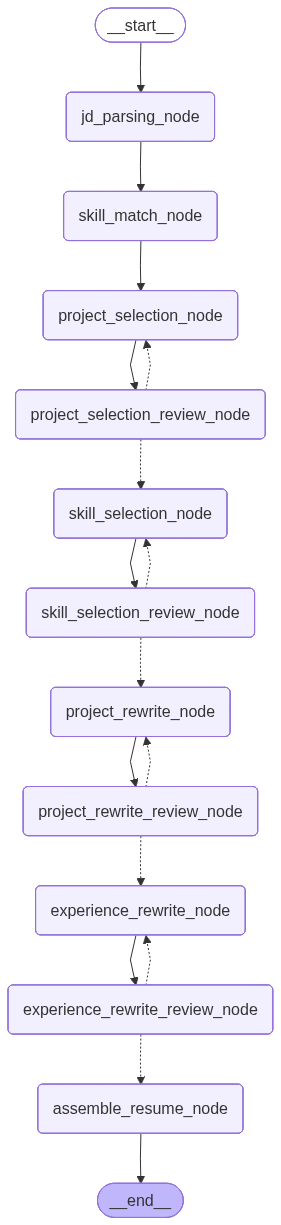

In [34]:
from langgraph.checkpoint.memory import InMemorySaver

tailor_graph = StateGraph(TailorState)

tailor_graph.add_node("jd_parsing_node", jd_parsing_node)
tailor_graph.add_node("skill_match_node", skill_match_node)
tailor_graph.add_node("project_selection_node", project_selection_node)
tailor_graph.add_node("project_selection_review_node", project_selection_review_node)
tailor_graph.add_node("skill_selection_node", skill_selection_node)
tailor_graph.add_node("skill_selection_review_node", skill_selection_review_node)
tailor_graph.add_node("project_rewrite_node", project_rewrite_node)
tailor_graph.add_node("project_rewrite_review_node", project_rewrite_review_node)
tailor_graph.add_node("experience_rewrite_node", experience_rewrite_node)
tailor_graph.add_node("experience_rewrite_review_node", experience_rewrite_review_node)
tailor_graph.add_node("assemble_resume_node", assemble_resume_node)

tailor_graph.add_edge(START, "jd_parsing_node")
tailor_graph.add_edge("jd_parsing_node", "skill_match_node")
tailor_graph.add_edge("skill_match_node", "project_selection_node")
tailor_graph.add_edge("project_selection_node", "project_selection_review_node")
tailor_graph.add_conditional_edges(
    "project_selection_review_node",
    should_reselect_projects,
    ["project_selection_node", "skill_selection_node"],
)
tailor_graph.add_edge("skill_selection_node", "skill_selection_review_node")
tailor_graph.add_conditional_edges(
    "skill_selection_review_node",
    should_reselect_skills,
    ["skill_selection_node", "project_rewrite_node"],
)
tailor_graph.add_edge("project_rewrite_node", "project_rewrite_review_node")
tailor_graph.add_conditional_edges(
    "project_rewrite_review_node",
    should_rewrite_projects,
    ["project_rewrite_node", "experience_rewrite_node"],
)
tailor_graph.add_edge("experience_rewrite_node", "experience_rewrite_review_node")
tailor_graph.add_conditional_edges(
    "experience_rewrite_review_node",
    should_rewrite_experience,
    ["experience_rewrite_node", "assemble_resume_node"],
)
tailor_graph.add_edge("assemble_resume_node", END)

tailor_agent = tailor_graph.compile(checkpointer=checkpointer)
display(Image(tailor_agent.get_graph(xray=True).draw_mermaid_png()))

In [42]:
config: RunnableConfig = {"configurable": {"thread_id": "6"}}

In [ ]:
import json
from utils.serialize import serialize_output

NODE_LABELS = {
    "jd_parsing_node": "Parsing job description",
    "skill_match_node": "Matching skills",
    "project_selection_node": "Selecting projects",
    "skill_selection_node": "Selecting skills",
    "project_rewrite_node": "Rewriting project bullets",
    "experience_rewrite_node": "Rewriting experience bullets",
    "assemble_resume_node": "Assembling resume",
}

STRUCTURED_OUTPUT_NODES = {
    "jd_parsing_node",
    "skill_match_node",
    "project_selection_node",
    "skill_selection_node",
    "project_rewrite_node",
    "experience_rewrite_node",
}

events = tailor_agent.astream_events(
    {
        "raw_html": description_html,
        "resume_json": ingestion_agent_response["resume_json"],
    },
    config=config,
)

async for event in events:
    event_name = event["event"]
    name = event["name"]
    node = event.get("metadata", {}).get("langgraph_node", "")

    if event_name == "on_chain_start" and name == node and node in NODE_LABELS:
        print(
            f"data: {json.dumps({'type': 'node_start', 'label': NODE_LABELS[node]})}\n\n"
        )

    elif (
        event_name == "on_chain_end"
        and name == node
        and node in STRUCTURED_OUTPUT_NODES
    ):
        output = event["data"].get("output", {})
        serialized = serialize_output(output)
        print(
            f"data: {json.dumps({'type': 'node_data', 'node': node, 'data': serialized})}\n\n"
        )

final_state = tailor_agent.get_state(config)
if final_state.next:
    current_node = final_state.next[0]
    print(f"data: {json.dumps({'type': 'interrupt', 'node': current_node})}\n\n")
else:
    print(f"data: {json.dumps({'type': 'complete'})}\n\n")

data: {"type": "node_start", "label": "Parsing job description"}




/home/athreya/miniconda3/envs/resume-tailor/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=JDResponseSchema(location...-native architectures']), input_type=JDResponseSchema])
  return self.__pydantic_serializer__.to_python(


data: {"type": "node_data", "node": "jd_parsing_node", "data": {"jd_json": {"location": "Ireland or Lithuania (Hybrid or Home-based)", "responsibilities": ["Analyze user workflows and challenges to identify opportunities for AI enhancement.", "Implement AI features using LangChain and MCP tooling.", "Participate in improving AI/ML models using best practices (e.g., deep learning, LLMs).", "Define evaluation metrics and usage telemetry for AI models.", "Stay current with AI research and trends; bring ideas on technical trade-offs and innovation.", "Present POCs and prototypes to users for feedback and iteration.", "Design and implement scalable, maintainable desktop application features.", "Develop and maintain core components and services, including Azure-based cloud integrations.", "Follow secure development practices and DevOps processes from design to delivery.", "Build and maintain CI/CD pipelines for automated testing and deployment.", "Support and maintain existing codebases; men

/home/athreya/miniconda3/envs/resume-tailor/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=SemanticMatchResponseSche...matched_nice_to_have=[]), input_type=SemanticMatchResponseSchema])
  return self.__pydantic_serializer__.to_python(


data: {"type": "node_data", "node": "skill_match_node", "data": {"skill_match_results": {"matched_must_have": ["generative ai", "cloud platforms", "software development", "containerization", "git", "langchain", "docker", "model fine-tuning", "open-source ai models"], "missing_must_have": ["data structures", "scrum", "llama", "jira", "prompt engineering", "ci/cd", "typescript", "maintainable code", "secure code", "oop", "mistral", "agile", "js testing frameworks", "linux", "devops", "testable code", "ollama", "react"], "matched_nice_to_have": [], "missing_nice_to_have": ["functional programming", "cloud-native architectures", "mlops", "electron", "azure devops", "sqlite"], "must_have_score": 0.333, "nice_to_have_score": 0.0, "final_score": 0.233}}}


data: {"type": "node_start", "label": "Selecting projects"}


data: {"type": "node_data", "node": "project_selection_node", "data": {"selected_projects": [{"title": "End-to-End Retrieval-Augmented Generation System", "description": "Archite

/home/athreya/miniconda3/envs/resume-tailor/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ProjectSelectResponseSche...ication.'], link=None)]), input_type=ProjectSelectResponseSchema])
  return self.__pydantic_serializer__.to_python(


In [44]:
from langgraph.types import Command

feedback = {"approved": True, "feedback": "This is a feedback"}


events = tailor_agent.astream_events(Command(resume=feedback), config)

async for event in events:
    event_name = event["event"]
    name = event["name"]
    node = event.get("metadata", {}).get("langgraph_node", "")
    print(event)
    print(f"{name=}, {node=}")

    if event_name == "on_chain_start" and name == node and node in NODE_LABELS:
        print(
            f"data: {json.dumps({'type': 'node_start', 'label': NODE_LABELS[node]})}\n\n"
        )

    elif (
        event_name == "on_chain_end"
        and name == node
        and node in STRUCTURED_OUTPUT_NODES
    ):
        output = event["data"].get("output", {})
        serialized = serialize_output(output)
        print(
            f"data: {json.dumps({'type': 'node_data', 'node': node, 'data': serialized})}\n\n"
        )

final_state = tailor_agent.get_state(config)
if final_state.next:
    current_node = final_state.next[0]
    print(f"data: {json.dumps({'type': 'interrupt', 'node': current_node})}\n\n")
else:
    print(f"data: {json.dumps({'type': 'complete'})}\n\n")

{'event': 'on_chain_start', 'data': {'input': Command(resume={'approved': True, 'feedback': 'This is a feedback'})}, 'name': 'LangGraph', 'tags': [], 'run_id': '019c9b4f-3790-7492-af8c-39fcc5ffcfc7', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
name='LangGraph', node=''
{'event': 'on_chain_start', 'data': {'input': TailorState(raw_html='<div class="show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden">\n          Bentley Systems<br/><br/><strong>AI Engineer <br/><br/></strong><strong>Location: Ireland or Lithuania (Hybrid or Home-based)<br/><br/></strong><strong>Why Bentley Systems?\u202f <br/><br/></strong><ul><li>Innovative Projects:\u202fWork on SYNCHRO, cutting-edge 4D construction planning and project management suite.\u202f </li><li>Professional Growth:\u202fOpportunities for continuous learning and career advancement.\u202f </li><li>Competitive Compensation:\u202fAttractive salary package starting from 4800 EUR gross (before taxes-

/home/athreya/miniconda3/envs/resume-tailor/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=SkillSelectionResponse(se...ython', 'JavaScript'])]), input_type=SkillSelectionResponse])
  return self.__pydantic_serializer__.to_python(


In [ ]:
from jinja2 import Environment, FileSystemLoader

tailored_resume = tailor_agent_response["tailored_resume_json"]


def latex_escape(text):
    if not isinstance(text, str):
        return text
    return (
        text.replace("&", "\\&")
        .replace("%", "\\%")
        .replace("$", "\\$")
        .replace("#", "\\#")
        .replace("_", "\\_")
    )


env = Environment(
    loader=FileSystemLoader("."),
    block_start_string="((*",
    block_end_string="*))",
    variable_start_string="(((",
    variable_end_string=")))",
    comment_start_string="((#",
    comment_end_string="#))",
    finalize=latex_escape,
    trim_blocks=True,
    lstrip_blocks=True,
)


template = env.get_template("resume.tex")
output = template.render(**tailored_resume.model_dump())

In [ ]:
import subprocess
import tempfile
import os


def render_to_pdf(latex_content: str) -> bytes:
    with tempfile.TemporaryDirectory() as tmpdir:
        tex_path = os.path.join(tmpdir, "resume.tex")
        pdf_path = os.path.join(tmpdir, "resume.pdf")

        with open(tex_path, "w") as f:
            f.write(latex_content)

        subprocess.run(
            [
                "pdflatex",
                "-interaction=nonstopmode",
                "-output-directory",
                tmpdir,
                tex_path,
            ],
            check=True,
            capture_output=True,
        )

        with open(pdf_path, "rb") as f:
            return f.read()

In [43]:
pdf_bytes = render_to_pdf(output)

with open("resume.pdf", "wb") as f:
    f.write(pdf_bytes)